# Levenshtein distance and spelling corrections


In [98]:
from spacy.tokenizer import Tokenizer
from spacy.lang.pl import Polish
import os
import numpy as np
import matplotlib.pyplot as plt
from Levenshtein import distance
import time
import itertools
from elasticsearch import Elasticsearch, helpers
from statistics import mean 

In [24]:
nlp = Polish()

In [25]:
tokenizer = Tokenizer(nlp.vocab)

In [26]:
files_names = []

for file_name in os.listdir('../../ustawy'):
    if file_name.endswith('.txt'):
        files_names.append(os.path.join("../../ustawy", file_name))

In [27]:
frequency_list = []

for file_name in files_names:
    with open(file_name, encoding='utf-8') as file:
        doc = file.read()
        doc = doc.lower()
        tokens = tokenizer(doc)
        doc_tokens = {
            'file_name' : file_name,
            'tokens_with_frequency' : {}
        }
        
        for token in tokens:
            doc_tokens['tokens_with_frequency'][token.text] = doc_tokens['tokens_with_frequency'].get(token.text, 0) + 1
            
        frequency_list.append(doc_tokens)

Stworzyłam listę, w której zawarte są słowniki zawierające nazwę pliku ustawy oraz słownik tokenów zawierający odzwierciedlenie tokenu (słowa) na liczbę wystąpień tokenu.

In [28]:
global_frequency_list = {}

for file_list in frequency_list:
    for token, frequency in file_list['tokens_with_frequency'].items():
        if len(token) >= 2 and token.isalpha():
            global_frequency_list[token] = global_frequency_list.get(token, 0) + frequency

Zamieniłam listę na pojedynczy globalny słownik mający jako klucze tokeny, a jako wartości liczbę wystąpień danego tokenu. Równocześnie przy zliczaniu tokenów i wkładaniu ich do nowego słownika usuwam wyrazy krótsze niż 2 litery oraz wszystkie nie alfanumeryczne znaki (polskie znaki zostały).

In [29]:
global_frequency_list_sorted_by_name = {k: v for k, v in sorted(global_frequency_list.items(), key= lambda item: item[0])}

In [30]:
global_frequency_list_sorted = {k: v for k, v in sorted(global_frequency_list_sorted_by_name.items(), key= lambda item: item[1], reverse=True)}

Aby poprawnie posortować słownik wykonałam najpierw sortowanie alfabetyczne, a potem po ilości wystąpień tokenu.

In [31]:
x = list(range(len(global_frequency_list_sorted.keys())))

In [32]:
y = list(global_frequency_list_sorted.values())

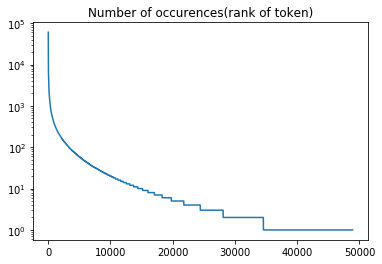

In [33]:
plt.figure()
plt.plot(x, y)
plt.yscale('log')
plt.title('Number of occurences(rank of token)')
plt.show()

Można zauważyć, że liczba wystąpień wyrazów spada ostro na początku, a później stopniowo wypłaszcza się.

In [34]:
polimorfologik_dict = {}

In [35]:
with open('../../polimorfologik-2/polimorfologik-2.1.txt', 'r') as dict_f:
    for line in dict_f:
        l_content = line.split(';')
        polimorfologik_dict[l_content[0]] = polimorfologik_dict.get(l_content[0], []) + [l_content[1].lower()]

Wczytuję wyrazy do słownika, aby uniknąć powtarzających się form.

In [69]:
polimorfologik_list = [[k] + v for k,v in polimorfologik_dict.items()]
polimorfologik_list = list(itertools.chain.from_iterable(polimorfologik_list))

Wykonałam spłaszczenie zagnieżdżonych list.

### 30 słów o największej liczbie wystąpień, którch nie ma w słowniku Polimorfologik

In [71]:
i = 0
tokens_not_found = []

for token, freq in global_frequency_list_sorted.items():
    if token.lower() not in polimorfologik_list:
        i += 1
        tokens_not_found.append(token)
        print(token + ' ' + str(freq))
    if i == 30:
        break

gmo 192
skw 184
sa 182
ex 155
iv 148
ike 116
vi 87
kn 84
cn 77
uke 74
ure 74
sww 72
vii 64
phs 52
udt 52
remediacji 51
bswsg 42
bswp 39
viii 34
pkwiu 29
fep 27
ix 27
pcn 27
ose 26
uokik 26
doręczeń 25
frd 25
plk 25
inulinowego 24
xi 24


### 30 słów liczbie wystąpień równej 5, którch nie ma w słowniku Polimorfologik

In [75]:
i = 0
tokens_not_found_freq5 = []
global_frequency_list_sorted_5 = {k: v for k, v in global_frequency_list_sorted.items() if v == 5}

for token, freq in global_frequency_list_sorted_5.items():
    if token.lower() not in polimorfologik_list:
        i += 1
        tokens_not_found_freq5.append(token)
        print(token + ' ' + str(freq))
    if i == 30:
        break

agave 5
ami 5
anonimizacji 5
badawczorozwojowych 5
dostosowań 5
iib 5
izobutyl 5
jed 5
ktrej 5
najmnie 5
naliczeń 5
nawodnień 5
nawozw 5
nfośigw 5
nusp 5
odgazowywacze 5
odwzorowań 5
ośc 5
poddziałań 5
ponadzakładowym 5
pozaaptecznego 5
ppkt 5
przepisw 5
próbobiorców 5
regazyfikacyjnego 5
rekapitalizacyjnej 5
rozmnożeń 5
sanitarnoepidemiologicznych 5
sposb 5
teryto 5


In [76]:
def correctLevenshtein(word, max_distance=2, max_corrections=5):
    found = 1
    corrections = []
    for token in global_frequency_list_sorted.keys():
        if distance(token.lower(), word.lower()) <= max_distance:
            found += 1
            corrections.append(token)
        if found == max_corrections:
            break
    return corrections

In [92]:
correction_times = []
for word in tokens_not_found_freq5:
    start = time.time()
    corrections = correctLevenshtein(word)
    end = time.time()
    t = round(end-start, 3)
    correction_times.append(t)
    print(word + ' - Time(' + str(t) + ' s)\n')
    for correction in corrections:
        print(correction)
    print('\n')

agave - Time(0.083 s)

agave


ami - Time(0.001 s)

dni
ma
mu
ani


anonimizacji - Time(0.059 s)

anonimizacji


badawczorozwojowych - Time(0.067 s)

badawczorozwojowych
badawczorozwojowymi


dostosowań - Time(0.021 s)

dostosować
dostosowane
zastosowań
dostosowany


iib - Time(0.0 s)

lub
się
nie
ich


izobutyl - Time(0.049 s)

izobutyl
izobutylid
izobuty
izobutyli


jed - Time(0.0 s)

od
jest
jego
ze


ktrej - Time(0.003 s)

której
które
tej
karnej


najmnie - Time(0.024 s)

najmniej
nadanie
najmie
najmnie


naliczeń - Time(0.016 s)

odliczeń
zaliczek
nalicza
obliczeń


nawodnień - Time(0.077 s)

odwodnień
nawodnień


nawozw - Time(0.005 s)

nawóz
nawozu
nawozy
nawozów


nfośigw - Time(0.055 s)

nfośigw


nusp - Time(0.006 s)

nbp
musi
ust
nip


odgazowywacze - Time(0.062 s)

odgazowywacze


odwzorowań - Time(0.07 s)

odwzorowań


ośc - Time(0.001 s)

od
moc
on
one


poddziałań - Time(0.069 s)

poddziałań


ponadzakładowym - Time(0.028 s)

ponadzakładowy
ponadzakładowych
ponadzakłado

## ElasticSearch

In [82]:
es = Elasticsearch([{'host': 'localhost', 'port': 9200}])

In [83]:
es.indices.create(
    index='autocorrection_index',
    body={
        "settings": {
            "analysis": {
                "analyzer": {
                    "default": {
                        "type": "custom",
                        "tokenizer": "keyword"
                    }
                }
            }
        }
    }
)

{'acknowledged': True,
 'shards_acknowledged': True,
 'index': 'autocorrection_index'}

In [84]:
query = []
for word in global_frequency_list_sorted:
    body = {
        '_index': 'autocorrection_index',
        'word': word
    }
    query.append(body)
helpers.bulk(es, query)

(48909, [])

### Fuzzy matching 

In [93]:
correction_times_es = []
for word in tokens_not_found_freq5:
    f_search = {
        'query':{
            'fuzzy':{
                'word': word
            },
        }
    }
    start = time.time()
    corrections = es.search(index='autocorrection_index', body=f_search)
    end = time.time()
    t = round(end-start, 4)
    correction_times_es.append(t)
    print(word + ' - ' + str(t) + 's: ')
    for correction in corrections['hits']['hits'][:5]:
        print(correction['_source']['word'])
    print()

agave - 0.0151s: 
agave

ami - 0.0069s: 
ami
ani
sami
amo
amid

anonimizacji - 0.0111s: 
anonimizacji

badawczorozwojowych - 0.0112s: 
badawczorozwojowych
badawczorozwojowymi

dostosowań - 0.0114s: 
dostosowań
dostosować
dostosowane
zastosowań
dostosowany

iib - 0.0052s: 
iib
iii
izb
iia
iiib

izobutyl - 0.0082s: 
izobutyl
izobutyli
izobuty
izobutylid

jed - 0.0095s: 
jed
jej
jeż
je

ktrej - 0.0059s: 
ktrej
której
ktre

najmnie - 0.0078s: 
najmnie
najmniej
najmie
najmni
nadanie

naliczeń - 0.013s: 
naliczeń
zaliczeń
odliczeń
zaliczek
obliczeń

nawodnień - 0.011s: 
nawodnień
odwodnień

nawozw - 0.0084s: 
nawozw
nawozu
nawozy
nawozów
nawozo

nfośigw - 0.0103s: 
nfośigw

nusp - 0.0042s: 
nusp

odgazowywacze - 0.0093s: 
odgazowywacze

odwzorowań - 0.0111s: 
odwzorowań

ośc - 0.005s: 
ośc
ości
ość
oś

poddziałań - 0.011s: 
poddziałań

ponadzakładowym - 0.0177s: 
ponadzakładowym
ponadzakładowymi
ponadzakładowy
ponadzakładowych
ponadzakładowej

pozaaptecznego - 0.0095s: 
pozaaptecznego

ppkt 

## Results comparison

#### the distribution of words in the corpus

Dystrybucja słów w ustawach:
na wykresie można zauważyć, że występuje ok. 10 000 słów powtarzających się częściej niż 100 razy. Zatem słów powtarzających się bardzo dużo razy jest stosunkowo niewiele. Natomiast w przypadku słów powtarzających się kilka razy im jest mniej powtórzeń tym więcej słów w tej grupie (stąd schodkowy wykres z wydłużającym się stopniem).

#### the number of true misspellings vs. the number of unknown words

W większości przypadków wśród znalezionych słów znajdują się słowa nieznane słownikowi. Są to między innymi skróty np. gmo czy cyfry rzymskie np. viii. Natomiast przy słowach o frekwencji równej 5 znalazło się trochę więcej słów z literówkami np. ktrej lub najmnie. Literówki, jeśli już się zdarzają, to raczej występują z niską frekwencją.

#### the performance of your method compared to ElasitcSearch

In [101]:
print('My method mean time: ' + str(mean(correction_times)) + ' s')
print('ES mean time: ' + str(mean(correction_times_es)) + ' s')

My method mean time: 0.0387 s
ES mean time: 0.009863333333333333 s


Metoda ElasticSearch jest do około 4 razy szybsza od mojej w najgorszym przypadku, a w najlepszym jest tak samo lub niewiele szybsza. Jest to zależne od szukanych korekcji. Obie metody są wystarczająco szybkie dla takiej ilości korekcji, moja potrzebuje ok. 0.04 sekundy w sumie, a ES ok. 0.01 sekundy. Natomiast ES znajduje często dodatkowe propozycje korekcji w stosunku do mojego.

#### the results provided by your method compared to ElasticSearch

Tak jak powyżej, ElasticSearch znajduje czasami więcej korekcji, ale także często proponuje bardziej prawdopodobne słowa niż moja metoda np. ośc - moja metoda: od, moc, on, one, a ES: ośc, ości, ość, oś. W tym wypadku w mojej metodzie wogóle nie pojawiły się słowa związane z ościami. W niektórych przypadkach ES nie poradził sobie lepiej niż moja metoda np. nawozw, moja metoda: nawóz, nawozu, nawozy, nawozów, a ES: nawozw, nawozu, nawozy, nawozów, nawozo - tutaj brakuje całkiem dobrej korekcji nawóz, która pojawiła się w mojej metodzie.

#### the validity of the obtained corrections

ElasticSearch czasem dostarcza więcej korekcji, ale wydaje mi się, że zbyt skomplikowanych. Natomiast moja metoda dostarcza prostszych, ale przez to bardziej prawdopodobnych korekcji.